# Code for sparse coding of spectrotemporal data
*Nhat Le, Sep 2017*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.io.wavfile
import scipy.signal
import glob
import skimage.io
from sklearn.decomposition import PCA
import seaborn as sns

%matplotlib inline

In [2]:
def T(u, lamb, norm_type):
    '''Threshold function with the appropriate norm type (L0 or L1)'''
    if norm_type == 'L0':
        return max(u, 0.0)
    elif norm_type == 'L1':
        return max(u - lamb, 0.0)
    else:
        raise ValueError('Invalid norm type')

# Vectorized version of T        
T_vec = np.vectorize(T)
    
def find_s(tau, A, y, lamb, niter=100, update='paper', verbose=False):
    '''Perform LCA to find the sparse representation s, given a dictionary
    of features, A, and target y. Returns optimal s, and best cost.
    lamb: weight of sparsity constraint 
    tau: learning rate'''
    # Initialize
    best_cost = np.inf
    cost_prev = np.inf
    y = y[:, np.newaxis]
    s = np.zeros((A.shape[1], 1), dtype='float')
    best_s = np.zeros((A.shape[1], 1), dtype='float')
    u = np.zeros((A.shape[1], 1), dtype='float')
    
    # Start competition
    for i in range(niter):
        print('Starting iteration #', i, '...')
        if update == 'direct':
            ds = np.dot(A.T, y) - np.dot(np.dot(A.T, A), s) - np.sign(s)
            s += ds * tau
        elif update == 'paper':
            du = np.dot(A.T, y) - np.dot(np.dot(A.T, A), s) - np.sign(s)
            
            u += du * tau
            print(u)
            s = T_vec(u, lamb, norm_type='L1')
            print(s)
            
        cost = 0.5 * np.linalg.norm(y - np.dot(A, s))**2 + lamb * np.linalg.norm(s, ord=1)
        if cost <= cost_prev:
            tau *= 1.05
        else:
            tau *= 0.5
        
        cost_prev = cost
            
        if cost < best_cost:
            best_cost = cost
            best_s = s
        
        if verbose:
            print('Cost = ', cost, '. tau =', tau)
    print('Best cost = ', best_cost, 'Best s =', best_s.T)
    return best_s, best_cost


def find_s_batch(tau, A, Y, lamb, niter=100, update='paper', verbose=False):
    '''Find s for each target, given a collection of targets Y.
    Returns a matrix S: n_neurons x n_targets, and the best cost
    lamb: weight of sparsity constraint 
    tau: learning rate'''
    best_cost = np.inf
    cost_prev = np.inf
    S = np.zeros((A.shape[1], Y.shape[1]), dtype='float')
    best_S = np.zeros((A.shape[1], Y.shape[1]), dtype='float')
    U = np.zeros((A.shape[1], Y.shape[1]), dtype='float')
    for i in range(niter):
        print('Starting iteration #', i, '...')
        if update == 'direct':
            ds = np.dot(A.T, Y) - np.dot(np.dot(A.T, A), S) - np.sign(S)
            S += ds * tau
        elif update == 'paper':
            du = np.dot(A.T, Y) - np.dot(np.dot(A.T, A), S) - np.sign(S)
            
            U += du * tau
            
            S = T_vec(U, lamb, norm_type='L1')
            
        diff = (Y - np.dot(A, S)).ravel()
        cost = 0.5 * np.linalg.norm(diff)**2 + lamb * np.linalg.norm(S.ravel(), ord=1)
        #print('cost: ', cost)
        if cost <= cost_prev:
            tau *= 1.05
        else:
            tau *= 0.5
        
        cost_prev = cost
            
        if cost < best_cost:
            best_cost = cost
            best_S = S
        
        if verbose:
            print('Cost = ', cost, '. tau =', tau)
    print('Best cost = ', best_cost)
    return best_S, best_cost

In [3]:
A = np.array([[1,3,4, 8], [4,5,6, 2], [0,8,11, 3]], dtype='float')
y1 = np.array([30, 49, 79], dtype='float')
tau = 0.1
lamb = 0.0001
v1, e1 = find_s(tau, A, y1, lamb, niter=1, update='paper')

Starting iteration # 0 ...
[[  22.6]
 [  96.7]
 [ 128.3]
 [  57.5]]
[[  22.5999]
 [  96.6999]
 [ 128.2999]
 [  57.4999]]
Best cost =  4377813.34211 Best s = [[  22.5999   96.6999  128.2999   57.4999]]


In [4]:
y2 = np.array([20, 10, 60], dtype='float')
v2, e2 = find_s(tau, A, y2, lamb, niter=1, update='paper')

Starting iteration # 0 ...
[[  6.]
 [ 59.]
 [ 80.]
 [ 36.]]
[[  5.9999]
 [ 58.9999]
 [ 79.9999]
 [ 35.9999]]
Best cost =  1647875.24081 Best s = [[  5.9999  58.9999  79.9999  35.9999]]


In [5]:
Y = np.hstack((y1[:,np.newaxis], y2[:,np.newaxis]))
V = find_s_batch(tau, A, Y, lamb, niter=1, update='paper')
V

Starting iteration # 0 ...
Best cost =  6025688.58291


(array([[  22.5999,    5.9999],
        [  96.6999,   58.9999],
        [ 128.2999,   79.9999],
        [  57.4999,   35.9999]]), 6025688.5829102108)

In [6]:
def learn_step(y, A, s, eta, theta):
    '''Update the dictionary A of receptive fields, given the vector s 
    eta: learning rate to match s
    theta: learning rate used for de-correlating columns of A'''
    s = s[:, np.newaxis]
    y = y[:, np.newaxis]
    r = y - np.dot(A, s)
    A_new = A + eta * (np.dot(r, s.T)) + theta * (A - np.dot(A, np.dot(A.T, A)))
    return A_new

def learn_step_batch(Y, A, S, eta, theta):
    '''Update the dictionary A of receptive fields, given the matrix S of all activity vectors,
    and Y, a matrix containing all the training examples.
    eta: learning rate to match s
    theta: learning rate used for de-correlating columns of A'''
    R = Y - np.dot(A, S)
    A_new = A + eta * (np.dot(R, S.T)) + theta * (A - np.dot(A, np.dot(A.T, A)))
    return A_new

def do_multiple_learn_steps(y, A, s, eta, theta, nsteps=10, verbose=False):
    '''Perform multiple steps of learning A
    eta: learning rate to match s
    theta: learning rate used for de-correlating columns of A'''
    prev_cost = np.inf
    best_cost = np.inf
    A_best = A
    for i in range(nsteps):
        if y.ndim == 1: # Single example
            A = learn_step(y, A, s, eta, theta)
            cost = np.linalg.norm(y - np.dot(A, s))**2
        else: # batch
            assert(y.shape[1] == s.shape[1])
            A = learn_step_batch(y, A, s, eta, theta)
            diff = (y - np.dot(A, s)).ravel()
            cost = 0.5 * np.linalg.norm(diff)**2 + lamb * np.linalg.norm(s.ravel(), ord=1)
            #cost = np.linalg.norm(y - np.dot(A, s))**2
        if verbose:
            #print(A[0,:])
            print('Cost = ', cost, 'eta = ', eta, 'theta = ', theta)
        if cost < best_cost:
            best_cost = cost
            A_best = A
            
        if cost <= prev_cost:
            eta *= 1.05
            theta *= 1.05
        else:
            eta *= 0.5
            theta *= 0.5
        
        prev_cost = cost
    print('Best cost = ', best_cost)
        
    return A_best, best_cost

def find_optimal_A(y, s):
    '''Analytical solution for the best matrix A to match s'''
    assert(s.shape[1] == 1)
    y = y[:, np.newaxis]
    n = np.dot(s.T, s)[0,0]
    #print(s.shape, y.shape)
    return np.dot(y, 1.0 / n * s.T)

In [7]:
A = np.array([[1,3,4, 8], [4,5,6, 2], [0,8,11, 3]], dtype='float')
A = A / np.linalg.norm(A, axis=0)
s = np.array([3,3,4,5], dtype='float')
y = np.array([30, 49, 79], dtype='float')
eta = 0.001
theta = 0.0001

A_d = do_multiple_learn_steps(y, A, s, eta, theta, nsteps=100)

Best cost =  246.303859301


## Read and process sound files

In [8]:
def logfsgram(X, N=1024, SR=8000, WIN=1024, NOV=512, FMIN=80, BPO=12):
    '''Create a spectrogram whose frequency is log-sampled
    X: signal X is input signal; N is parent FFT window; SR is the source samplerate.
    WIN is actual window length within FFT, NOV is number of overlapping 
    points between successive windows.
    Optional FMIN is the lowest frequency to display (80Hz);
    BPO is the number of bins per octave (12).
    MX returns the nlogbin x nfftbin mapping matrix;
    sqrt(MX'*(Y.^2)) is an approximation to the original FFT
    spectrogram that Y is based on, suitably blurred by going 
    through the log-F domain.
    Source: dpwe@ee.columbia.edu
'''
    _,_,XX = scipy.signal.spectrogram(X, fs=SR, nfft=WIN, nperseg=N, noverlap=NOV)
    fratio = 2.0**(1 / BPO)
    nbins = np.floor(np.log((SR / 2) / FMIN) / np.log(fratio))
    fftfrqs = np.arange(N/2 + 1) * (SR / N)
    nfftbins = N/2 + 1
    logffrqs = FMIN * np.exp(np.log(2) * np.arange(nbins) / BPO)
    logfbws = logffrqs * (fratio - 1)
    logfbws = np.maximum(logfbws, SR/N)
    ovfctr = 0.5475

    replogffrqs = np.repeat(logffrqs[:,np.newaxis], nfftbins, axis=1)
    repfftfrqs = np.tile(fftfrqs, (int(nbins), 1))
    replogfbws = np.repeat(ovfctr * logfbws[:,np.newaxis], nfftbins, axis=1)

    freqdiff = (replogffrqs - repfftfrqs) / replogfbws
    mx = np.exp(-0.5 * freqdiff**2)
    divby = np.sqrt(2 * np.sum(mx**2, axis=1))
    divby = np.repeat(divby[:,np.newaxis], nfftbins, axis=1)
    mx = mx / divby
    spectrogram = np.sqrt(np.dot(mx, np.abs(XX)**2))
    return spectrogram, XX, f, t

In [9]:
# Read the American English files
soundfiles = glob.glob('./American-English/*/*.wav')
sound_combined = np.zeros(0)
X = sound_combined
for file in soundfiles:
    fs, sound = scipy.io.wavfile.read(file)
    sound_trim = np.trim_zeros(sound)
    sound_combined = np.concatenate((sound_combined, sound_trim))

In [ ]:
# Read bird song file
fs, sound_combined = scipy.io.wavfile.read('./songs_50_test_bird_0.15s.wav')
sound_combined = sound_combined[:,0]
f,t,spectrogram = scipy.signal.spectrogram(sound_combined, fs)
plt.figure(figsize=(20,5))
plt.imshow(np.flipud(spectrogram)[:50,:4000], cmap=plt.cm.bone, extent=[t[0], t[3999], f[0], f[49]], 
           aspect='auto');
plt.grid(False)
plt.title('Song spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)');

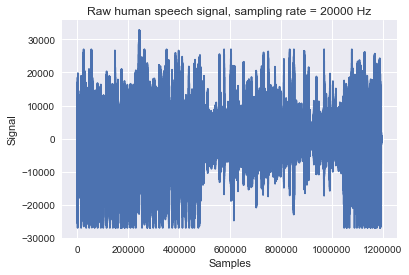

In [12]:
plt.plot(sound_combined)
#plt.ylim([-60000, 60000])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.title('Raw human speech signal, sampling rate = %d Hz' % fs);

In [ ]:
#p=TW determines spatial and temporal resolution
#k runs from 1,2,...2p-1, are the orthogonal modes which serve as 'samples' of the fft

In [ ]:
start = 0
seg = sound_combined[start:start+nperseg]
np.fft.fft(seg * window).shape

In [ ]:
np.lib.pad(window, (0, 100), 'constant', constant_values=(0, 0))

In [ ]:
window = scipy.signal.slepian(M=nperseg, width=NW / nperseg)
plt.plot(window)

In [14]:
def multitaper_spec(X, nadvance=200, slepian_len=500, nperseg=4096*4, NW=1):
    '''Perform a dpss multitapering
    Returns the spectrogram, frequency (f) and time ticks (t)'''

    # Use slepian window of width 0.3
    window = scipy.signal.slepian(M=slepian_len, width=NW / slepian_len)
    window = np.lib.pad(window, (0, nperseg - slepian_len), 'constant', constant_values=(0, 0))
    noverlap = len(window) - nadvance

    f,t,spectrogram = scipy.signal.spectrogram(X, fs, window=window, noverlap=noverlap)
    spectrogram = 20 * np.log10(spectrogram) #Units: dB
    
    return (f, t, spectrogram)

def sample_logspec(spectrogram, nsamples=256, fmin=100.0, fmax=4000.0):
    '''Sample the spectrogram tollect the required number of samples
    in frequency from fmin to fmax, logarithmically spaced
    Returns the spectrogram and the frequencies sampled'''
    # Frequencies to sample
    spacing = (np.log(fmax) - np.log(fmin)) / (nsamples - 1)
    logfreqs = np.log(fmin) + np.arange(nsamples) * spacing
    freqs = np.exp(logfreqs)

    # Sampled version
    row_ids = []
    for freq in freqs:
        row_ids.append(len(f[f < freq]))

    logspec = spectrogram[row_ids,:]
    return (logspec, freqs)

def format_func(value, tick_number):
    # find number of multiples of pi/2
    if value >= len(freqs):
        label = max(freqs)
    else:
        label = freqs[int(value)]
    return np.round(label, 1)



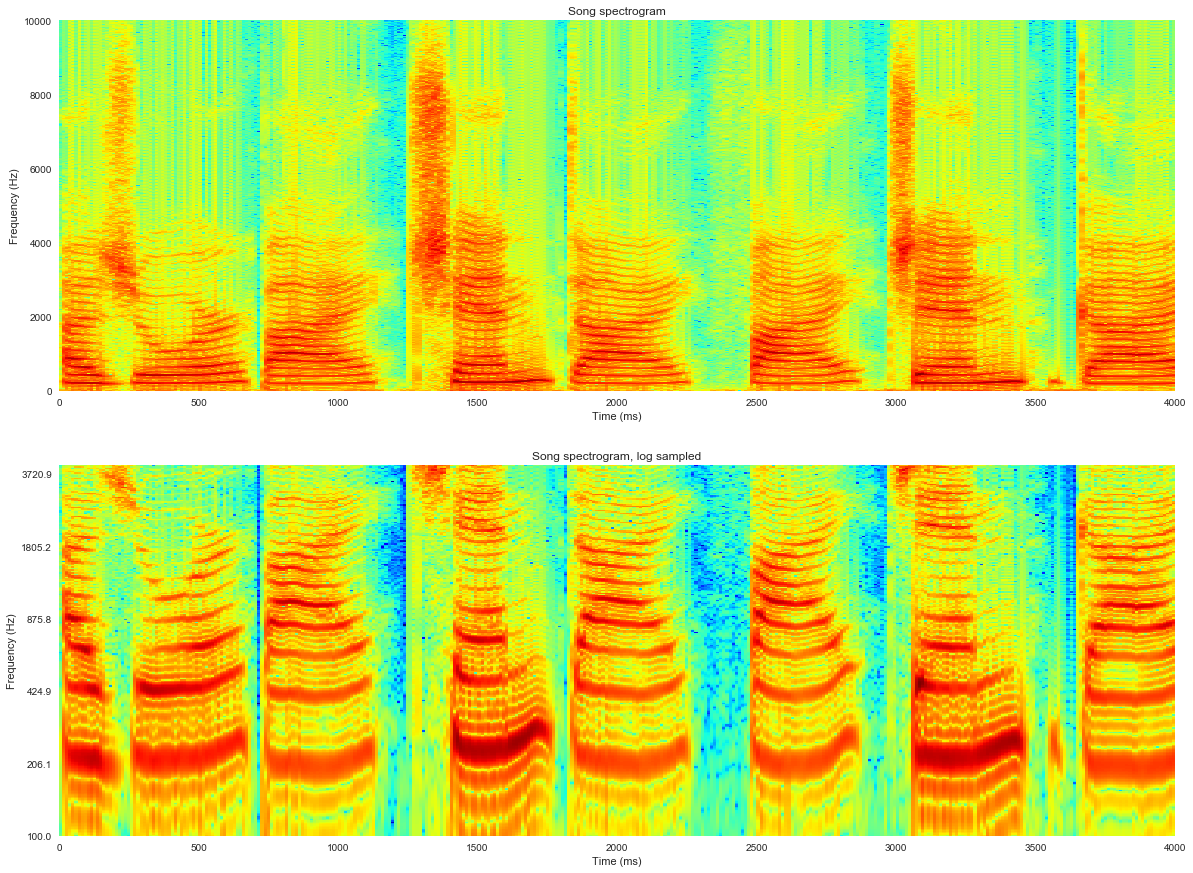

In [18]:
# Compute the spectrogram and log spectrogram
nadvance = 200
f,t,spectrogram = multitaper_spec(sound_combined, nadvance=nadvance)
logspec, freqs = sample_logspec(spectrogram)

# Time and frequency ranges for plotting
fmin = 0
fmax = 10000 #Hz
tmin = 0
tmax = 4000 #ms
f_start = len(f[f<fmin])
f_end = len(f[f<fmax])
t_start = len(t[t<tmin])
t_end = len(t[t<tmax/1000])


# Plot the spectrogram and log spectrogram
fig, ax = plt.subplots(2, 1, figsize=(20,15))
ax[0].imshow(np.flipud(spectrogram[f_start:f_end,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, fmin, fmax])
ax[0].grid(False)
ax[0].set_title('Song spectrogram')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Frequency (Hz)');

# For plotting

ax[1].imshow(np.flipud(logspec[:,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, 0, len(freqs)])
ax[1].grid(False)
ax[1].set_title('Song spectrogram, log sampled')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Frequency (Hz)');
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(format_func))

In [19]:
# Segment into overlapping segments
spectrogram = logspec
segment_len = 20 #samples
segment_step = 10 #samples
dt = segment_len * nadvance / fs * 1000 #length of each window in ms
segments_lst = []
for t_start in np.arange(0, len(t) - segment_len, segment_step):
    segments_lst.append(spectrogram[:,t_start:(t_start + segment_len)])
    
# Do pca on each segment
X = np.zeros((segments_lst[0].shape[0] * segments_lst[0].shape[1], len(segments_lst)))
for idx, segment in enumerate(segments_lst):
    X[:,idx] = segment.ravel()
# Perform pca with whitening
pca = PCA(n_components=200, whiten=True)
pca.fit(X.T)
Y = pca.transform(X.T).T    

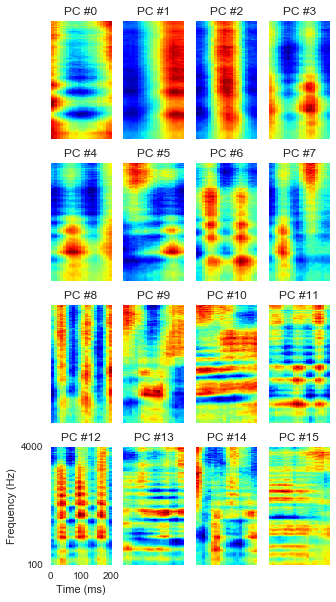

In [20]:
def format_func(value, tick_number):
    # find number of multiples of pi/2
    return value

# Visualize principal components
n_show = 4 #number of rows to show. will show n_show x n_show pca components
fig, ax = plt.subplots(n_show, n_show, figsize=(5,10))
comp = pca.components_

for i in range(n_show):
    for j in range(n_show):
        idx = n_show*i + j
        component = comp[idx,:].reshape((spectrogram.shape[0], segment_len))
        ax[i][j].grid(False)
        ax[i][j].imshow(np.flipud(component), cmap='jet', aspect='auto', extent=[0, dt, 100, 4000])
        #ax[i][j].set_yscale('log')
        ax[i][j].set_title('PC #' + str(idx))
        ax[i][j].set_ylim([100, 4000])
        if i != n_show - 1 or j != 0:
            ax[i][j].set(xticklabels=[], yticklabels=[])
        else:
            ax[i][j].set_xlabel('Time (ms)')
            ax[i][j].set_ylabel('Frequency (Hz)')
            #ax[i][j].yaxis.set_major_locator(plt.LogLocator(numticks=5))
            ax[i][j].yaxis.set_major_locator(plt.FixedLocator([100, 4000]))
            ax[i][j].yaxis.set_major_formatter(plt.FuncFormatter(format_func))
            
            #ax[i][j].set(yticklabels = [1000, 4000])
            #ax[i][j].set(yticklabels=[10, 4000])


## Start the learning

In [ ]:
# Set learning parameters
iters = 10 #number of iterations per s or A update
nfeats = 800 #number of neurons
lamb = 0.1 #weight of sparsity constraint
tau = 0.01 #changed 0.1 to 0.01 10/1 #learning rate for s update
eta = 0.01 #learning rate for A update
theta = 0.001 #learning rate for A update (orthogonalizing component)

In [ ]:
# Initialize and normalize A
A = np.random.rand(comp.shape[0], nfeats)
A /= np.linalg.norm(A, axis=0)
s_lst = []
A_lst = []

In [ ]:
def reconstruct(A, S, shape):
    '''Reconstruct the spectrogram, given a dictionary A of receptive fields,
    and s: the activity of neurons'''
    Y = np.dot(A, S)
    Y_inverted
    for ncol in range(Y.shape[1]):
        segment = np.reshape(Y[:,ncol], shape)
        
        

In [ ]:
# Read bird song file
fig, ax = plt.subplots(2, 1, figsize=(20,10))
ax[0].imshow(np.flipud(spectrogram), cmap=plt.cm.hot, extent=[t[0], t[-1], f[0], f[-1]], 
           aspect='auto');
ax[0].grid(False)
ax[0].set_title('Original song spectrogram')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Frequency (Hz)');

ax[1].imshow(np.flipud(recons), cmap=plt.cm.hot, extent=[t[0], t[-1], f[0], f[-1]], 
           aspect='auto');
ax[1].grid(False)
ax[1].set_title('Song spectrogram after reconstruction')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)');

In [ ]:
Y = np.dot(best_A, best_s)
Y_inverted = pca.inverse_transform(Y.T).T
segments = ()

for ncol in range(Y.shape[1]):
    segment = np.reshape(Y_inverted[:,ncol], (spectrogram.shape[0], segment_len))
    if ncol > 0:
        segment = segment[:, 15:]
    segments += (segment,)
recons = np.hstack(segments)

In [ ]:
Y = np.dot(best_A, best_s)
Y_inverted = pca.inverse_transform(Y.T).T
recons = np.zeros_like(spectrogram)


for ncol in range(Y.shape[1]):
    segment = np.reshape(Y_inverted[:,ncol], (spectrogram.shape[0], segment_len))
    start = ncol * segment_step
    recons[:,start:(start + segment_len)] += segment


In [ ]:
best_cost_s = np.inf
best_cost_A = np.inf
prev_cost_s = np.inf
prev_cost_A = np.inf
# Issue: In find_A: invalid value encountered in subtract
for i in range(30):
    print('#### Finding s, iteration ', i, '####')
    s,cost_s = find_s_batch(tau, A, Y, lamb, niter=iters, verbose=False)
    print('#### Finding A, iteration ', i, '####')

    A,cost_A = do_multiple_learn_steps(Y, A, s, eta=eta, theta=theta, nsteps=iters, verbose=False)
    A /= np.linalg.norm(A, axis=0)
    
    if cost_s <= prev_cost_s:
        tau *= 1.05
    else:
        tau *= 0.5
    
    if cost_A <= prev_cost_A:
        eta *= 1.05
        theta *= 1.05
    else:
        eta *= 0.5
        theta *= 0.5
        
    prev_cost_s = cost_s
    prev_cost_A = cost_A
        
    if i > 0 and cost_A < best_cost_A:
        best_cost_s = cost_s
        best_cost_A = cost_A
        best_s = s
        best_A = A
    

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(best_s, cmap='hot')
plt.grid(False)

## Visualize the receptive fields of the neurons

In [ ]:
5020/20

In [ ]:
n_show = 5

A_inverted = pca.inverse_transform(best_A.T)
with sns.axes_style('white'):
    fig, ax = plt.subplots(n_show, n_show, figsize=(15,15))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=None)
    for i in range(n_show):
        for j in range(n_show):
            seg = A_inverted[n_show*i + j,:].reshape((251, 20))
            
            # Scale to be between -1 and 1
            segmin = np.min(seg)
            segmax = np.max(seg)
            seg = seg / (segmax - segmin) * 2 - (segmax + segmin) / (segmax - segmin)
            #seg = seg / segmax
            
            ax[i][j].imshow(np.flipud(seg), cmap='jet', aspect='auto')
            ax[i][j].grid(False)
            ax[i][j].set(xticklabels=[], yticklabels=[])
            #ax[i][j].set_yscale("log")
            #ax[i][j].set_ylim([0, 100])
            


In [ ]:
plt.imshow(np.flipud(seg), cmap='jet', aspect='auto')
plt.yscale('log')
plt.ylim([0, 80])
plt.colorbar()

In [ ]:
seg.shape

In [ ]:
ax[0][0].set_yscale

In [ ]:
ax[i][j].set_yscale